In [1]:
from mmpose.apis import Pose2DInferencer, init_model
import cv2

from pyspark.sql.functions import row_number
from pyspark.sql.window import Window
import pandas as pd
from tqdm import tqdm
import gc
from operator import add
import torch
import numpy as np

In [2]:
cv2.__version__

'4.8.0'

In [3]:
#torch.backends.cudnn.benchmark = False

In [4]:
inferencer = Pose2DInferencer(device='cuda',
    model='rtmpose-l_8xb64-270e_coco-wholebody-256x192',
    det_model='yolox_tiny_8x8_300e_coco',
    det_cat_ids=[0],  # the category id of 'human' class
)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-l_simcc-coco-wholebody_pt-aic-coco_270e-256x192-6f206314_20230124.pth
08/05 00:20:55 - mmengine - WARNING - Failed to search registry with scope "mmpose" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmpose" is a correct scope, or whether the registry is initialized.
08/05 00:20:56 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_tiny_8x8_300e_coco/yolox_tiny_8x8_300e_coco_20211124_171234-b4047906.pth
08/05 00:20:56 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmeng

In [5]:
#inferencer = Pose2DInferencer('wholebody', device='cuda')

In [6]:
result_generator = inferencer('webcam', show=True, return_vis = True,return_datasample=False)
#cv2.destroyAllWindows()
#cv2.waitKey(0)
#cv2.destroyAllWindows()
#cv2.waitKey(1)
#result = next(result_generator)
results = [result for result in result_generator]
cv2.destroyAllWindows()

[ WARN:0@16.773] global cap_v4l.cpp:982 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@16.774] global obsensor_uvc_stream_channel.cpp:156 getStreamChannelGroup Camera index out of range
/home/kristian/mmpose/mmpose/apis/inferencers/base_mmpose_inferencer.py:179: UserWarning: Cannot open camera (ID=0)
  warnings.warn(f'Cannot open camera (ID={camera_id})')


In [7]:
result_generator = inferencer('demo.jpg', show=True, return_vis = True,return_datasample=False,wait_time=5)
#cv2.destroyAllWindows()
#cv2.waitKey(0)
#cv2.destroyAllWindows()
#cv2.waitKey(1)
#result = next(result_generator)
#results = [result for result in result_generator]
#cv2.destroyAllWindows()
#result_generator = inferencer('demo2.jpg', show=True, return_vis = True,return_datasample=False,wait_time=5)
result = next(result_generator)
cv2.destroyAllWindows()

Output()

/home/kristian/miniconda3/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an 
upcoming release, it will be required to pass the indexing argument. (Triggered internally at 
/opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

In [8]:
result['visualization'][0]

array([[[  0,  34,  59],
        [  0,  34,  59],
        [  1,  35,  60],
        ...,
        [  0,  33,  58],
        [  0,  33,  58],
        [  0,  33,  58]],

       [[  1,  35,  60],
        [  1,  35,  60],
        [  2,  36,  61],
        ...,
        [  0,  33,  58],
        [  0,  33,  58],
        [  0,  33,  58]],

       [[  3,  37,  62],
        [  3,  37,  62],
        [  3,  37,  62],
        ...,
        [  0,  33,  58],
        [  0,  33,  58],
        [  0,  33,  58]],

       ...,

       [[ 95,  74,  69],
        [ 94,  74,  67],
        [ 92,  71,  66],
        ...,
        [  2,   2,   2],
        [  1,   1,   1],
        [  0,   0,   0]],

       [[103,  84,  80],
        [ 99,  80,  74],
        [ 95,  76,  72],
        ...,
        [  2,   2,   2],
        [  1,   1,   1],
        [  0,   0,   0]],

       [[102,  84,  80],
        [ 98,  80,  76],
        [ 95,  76,  72],
        ...,
        [  2,   2,   2],
        [  1,   1,   1],
        [  0,   0,   0]]

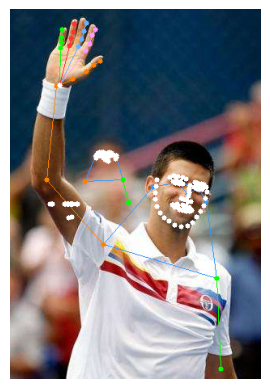

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the given data is stored in the variable 'data'
image_array = result['visualization'][0]

# Display the image using Matplotlib
plt.imshow(image_array, cmap='gray')
plt.axis('off')  # Hide the axis ticks and labels
plt.show()

In [10]:
import cv2
import numpy as np

# Assuming the given data is stored in the variable 'data'
image_array = result['visualization'][0]
bgr_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)

# Display the image using OpenCV
cv2.imshow('Color Image', bgr_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [11]:
# Open the video file
#video_path = 0
cap = cv2.VideoCapture("file://media/kristian/HDD/ASL_Citizen/ASL_Citizen/videos/0023159093449660606-CAFETERIA.mp4")
#cap = cv2.VideoCapture(0)

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        result_generator = inferencer(frame, show=False, return_vis = True,return_datasample=False)
        result = next(result_generator)
        image_array = cv2.cvtColor(result['visualization'][0], cv2.COLOR_RGB2BGR)
        # Display the annotated frame
        cv2.imshow("RTMPose Inference", image_array)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [12]:
result['predictions'][0][0]['keypoints']

[[339.4605529308319, 220.12040412425995],
 [367.8526143232982, 200.76218104362488],
 [312.3590397834778, 198.18108463287354],
 [397.53522396087646, 229.15424156188965],
 [278.8047854105632, 221.41095232963562],
 [473.6775704224905, 378.85783338546753],
 [233.63559683163965, 394.3444118499756],
 [557.563206354777, 485.97333443164825],
 [207.82463192939758, 501.4599128961563],
 [456.9004432360331, 464.03401494026184],
 [134.2633819580078, 620.1903477907181],
 [434.96112306912744, 620.1903477907181],
 [283.9669783910115, 620.1903477907181],
 [628.5433598359426, 620.1903477907181],
 [134.2633819580078, 439.5135990381241],
 [628.5433598359426, 465.3245631456375],
 [409.1501581668854, 620.1903477907181],
 [628.5433598359426, 489.84497904777527],
 [628.5433598359426, 431.77030980587006],
 [134.2633819580078, 620.1903477907181],
 [134.2633819580078, 311.7493267059326],
 [134.2633819580078, 425.3175687789917],
 [134.2633819580078, 620.1903477907181],
 [282.67643014589953, 202.05272924900055],
 

In [13]:
np.array(result['predictions'][0][0]['keypoints']).shape

(133, 2)

In [14]:
def extract_keypoints_from_file(filepath):
    # Open the video file
    cap = cv2.VideoCapture(filepath)

    # Initialize an empty list to store the keypoints for each frame
    keypoints = []

    # Loop through the frames of the video
    while cap.isOpened():
        # Read a frame from the video
        ret, frame = cap.read()
        if not ret:
            break

        result_generator = inferencer(frame, show=False, return_vis = False,return_datasample=False)
        result = next(result_generator)
        # Extract the keypoints from the YOLO results object
        if np.array(result['predictions'][0][0]['keypoints']).shape == (133, 2):
            keypoint = np.array(result['predictions'][0][0]['keypoints']).flatten()
        else:
            keypoint = np.zeros(266)

        # Append the keypoints to the list
        keypoints.append(keypoint)
        gc.collect()
        torch.cuda.empty_cache()
    # Release the video capture object and the YOLO model
    cap.release()

    # Convert the keypoints list to a NumPy array
    return np.array(keypoints)


In [15]:
result_generator = inferencer('webcam',
                              show=True, return_vis = True,return_datasample=False,
                              )
results = [result for result in result_generator]
cv2.destroyAllWindows()

[ WARN:0@57.920] global cap_v4l.cpp:982 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@57.920] global obsensor_uvc_stream_channel.cpp:156 getStreamChannelGroup Camera index out of range


In [16]:
test = extract_keypoints_from_file('file://media/kristian/HDD/ASL_Citizen/ASL_Citizen/videos/0023159093449660606-CAFETERIA.mp4')

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [17]:
test

array([[344.37766409, 236.8426218 , 371.10376692, ..., 291.6311326 ,
        107.85165405, 302.32157373],
       [344.70491695, 235.44906223, 371.2801644 , ..., 446.72228575,
        109.51397705, 445.39352334],
       [344.61565971, 233.35649872, 371.41310692, ..., 288.29126549,
        107.45825195, 293.65075493],
       ...,
       [340.20284867, 220.26719594, 368.73273667, ..., 287.70147872,
        134.00956726, 287.70147872],
       [339.49197435, 220.20398247, 367.88345353, ..., 287.311113  ,
        134.29901123, 287.311113  ],
       [339.46055293, 220.12040412, 367.85261432, ..., 287.2289108 ,
        134.26338196, 287.2289108 ]])

In [18]:
test.shape

(55, 266)

In [19]:
def signvideodataframe(filepath):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(filepath)

    # Define the path to the videos directory
    #path = 'file:///media/kristian/HDD/ASL_Citizen/ASL_Citizen/videos/'
    path = 'file:///home/kristian/ASL_Citizen/videos/'
    # Create a 'Path' column by concatenating the path with 'Video file' column
    df['Path'] = path + df['Video file']
    
#    df['Gloss'] = df['Gloss'].str.replace('\d+', '',regex=True)

    # Calculate the frequency of each gloss and create a 'frequency' column
    df['Frequency'] = df['Gloss'].map(df['Gloss'].value_counts())

    # Sort the DataFrame by the 'Gloss' column
    df = df.sort_values(by='Gloss')

    # Reset the index of the DataFrame
    df = df.reset_index(drop=True)

    return df

In [20]:
#traindf = signvideodataframe('file:///media/kristian/HDD/ASL_Citizen/ASL_Citizen/splits/train.csv')
traindf = signvideodataframe('file:///home/kristian/ASL_Citizen/splits/train.csv')

In [21]:
traindf.head()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
0,P31,3827306090663467-1 DOLLAR.mp4,1DOLLAR,C_02_025,file:///home/kristian/ASL_Citizen/videos/38273...,15
1,P37,16792698524451422-1 DOLLAR.mp4,1DOLLAR,C_02_025,file:///home/kristian/ASL_Citizen/videos/16792...,15
2,P11,6868778695018762-1 DOLLAR.mp4,1DOLLAR,C_02_025,file:///home/kristian/ASL_Citizen/videos/68687...,15
3,P11,6870709051348651-1 DOLLAR.mp4,1DOLLAR,C_02_025,file:///home/kristian/ASL_Citizen/videos/68707...,15
4,P50,0719792557216079-1 DOLLAR.mp4,1DOLLAR,C_02_025,file:///home/kristian/ASL_Citizen/videos/07197...,15


In [22]:
traindf.tail()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
40149,P37,9716493262876276-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///home/kristian/ASL_Citizen/videos/97164...,15
40150,P31,7550572181460327-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///home/kristian/ASL_Citizen/videos/75505...,15
40151,P46,47985881750082227-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///home/kristian/ASL_Citizen/videos/47985...,15
40152,P50,04671245574824856-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///home/kristian/ASL_Citizen/videos/04671...,15
40153,P51,19959052532136146-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///home/kristian/ASL_Citizen/videos/19959...,15


In [23]:
traindf['Path'][0]

'file:///home/kristian/ASL_Citizen/videos/3827306090663467-1 DOLLAR.mp4'

In [24]:
# Open the video file
#video_path = 0
cap = cv2.VideoCapture(traindf['Path'][0])
#cap = cv2.VideoCapture(0)

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        result_generator = inferencer(frame, show=False, return_vis = True,return_datasample=False)
        result = next(result_generator)
        image_array = cv2.cvtColor(result['visualization'][0], cv2.COLOR_RGB2BGR)
        # Display the annotated frame
        cv2.imshow("RTMPose Inference", image_array)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()

[ERROR:0@112.066] global cap.cpp:164 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.8.0) /io/opencv/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




In [25]:
traindf.sample(20)

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
16660,P31,3487251656390493-HELICOPTER.mp4,HELICOPTER2,D_02_042,file:///home/kristian/ASL_Citizen/videos/34872...,17
25161,P30,6289754558316547-PEEL 1.mp4,PEEL3,H_03_052,file:///home/kristian/ASL_Citizen/videos/62897...,16
5900,P33,08879237057426437-CHANGE.mp4,CHANGE,E_01_031,file:///home/kristian/ASL_Citizen/videos/08879...,13
33767,P30,32298123615365015-STRAWBERRY 3.mp4,STRAWBERRY2,K_03_100,file:///home/kristian/ASL_Citizen/videos/32298...,16
20545,P40,4736662703887722-LOCK.mp4,LOCK1,H_02_017,file:///home/kristian/ASL_Citizen/videos/47366...,18
39756,P30,43662643551648594-WRISTWATCH 2.mp4,WRISTWATCH3,K_03_044,file:///home/kristian/ASL_Citizen/videos/43662...,16
21315,P52,6409175794470368-seedMARRY.mp4,MARRY,F_02_007,file:///home/kristian/ASL_Citizen/videos/64091...,14
7219,P33,1386117593806433-COMMUNITY.mp4,COMMUNITY,J_01_015,file:///home/kristian/ASL_Citizen/videos/13861...,15
8843,P34,04531070862926345-DEFEAT.mp4,DEFEAT,G_03_090,file:///home/kristian/ASL_Citizen/videos/04531...,15
18179,P51,22099587835141832-INSTEAD.mp4,INSTEAD,H_01_079,file:///home/kristian/ASL_Citizen/videos/22099...,14


In [26]:
traindf = traindf[traindf['Frequency'] > 17]
traindf = traindf.reset_index(drop=True)

In [27]:
traindf.head()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
0,P52,07157565148825373-seedAXE.mp4,AXE1,G_03_066,file:///home/kristian/ASL_Citizen/videos/07157...,19
1,P28,7179300005186042-AXE.mp4,AXE1,G_03_066,file:///home/kristian/ASL_Citizen/videos/71793...,19
2,P29,16216064841959765-AXE.mp4,AXE1,G_03_066,file:///home/kristian/ASL_Citizen/videos/16216...,19
3,P37,6193814382865199-AXE.mp4,AXE1,G_03_066,file:///home/kristian/ASL_Citizen/videos/61938...,19
4,P40,5947453960317015-AXE.mp4,AXE1,G_03_066,file:///home/kristian/ASL_Citizen/videos/59474...,19


In [28]:
traindf.tail()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
945,P50,9161417844146778-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///home/kristian/ASL_Citizen/videos/91614...,20
946,P14,00930662603221255-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///home/kristian/ASL_Citizen/videos/00930...,20
947,P27,82063651021682-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///home/kristian/ASL_Citizen/videos/82063...,20
948,P40,5268072837528903-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///home/kristian/ASL_Citizen/videos/52680...,20
949,P40,6363286086951516-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///home/kristian/ASL_Citizen/videos/63632...,20


In [29]:
traindf.describe()

,Frequency
count,950.000000
mean,19.082105
std,1.316026
min,18.000000
25%,18.000000
50%,19.000000
75%,20.000000
max,24.000000


In [30]:
traindf['Gloss'].nunique()

50

In [31]:
words = traindf['Gloss'].unique()
words

array(['AXE1', 'BACKPACK1', 'BASKETBALL1', 'BEE1', 'BELT1', 'BITE1',
       'BREAKFAST1', 'CANCER1', 'CHRISTMAS1', 'CONFUSED1', 'DARK1',
       'DEAF1', 'DECIDE1', 'DEMAND1', 'DEVELOP1', 'DINNER1', 'DOG1',
       'DOWNSIZE1', 'DRAG1', 'EAT1', 'EDIT1', 'ELEVATOR1', 'FINE1',
       'FLOAT1', 'FOREIGNER1', 'GUESS1', 'HALLOWEEN1', 'HOSPITAL1',
       'HURDLE/TRIP1', 'JEWELRY', 'KNIGHT1', 'LOCK1', 'LUNCH1', 'MAPLE',
       'MEAT1', 'MECHANIC1', 'MICROSCOPE1', 'MOVIE1', 'NOON1', 'PARTY1',
       'PATIENT2', 'RAZOR2', 'RIVER1', 'ROCKINGCHAIR1', 'SHAVE1', 'SINK',
       'SQUEEZE', 'THEY1', 'TWINS1', 'WHATFOR1'], dtype=object)

In [32]:
#valdf = signvideodataframe('file:///media/kristian/HDD/ASL_Citizen/ASL_Citizen/splits/val.csv') 
valdf = signvideodataframe('file:///home/kristian/ASL_Citizen/splits/val.csv') 

In [33]:
valdf.head()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
0,P26,22595012150860327-1 DOLLAR.mp4,1DOLLAR,C_02_025,file:///home/kristian/ASL_Citizen/videos/22595...,3
1,P39,7421622940519235-1 DOLLAR.mp4,1DOLLAR,C_02_025,file:///home/kristian/ASL_Citizen/videos/74216...,3
2,P21,686738356933241-1 DOLLAR.mp4,1DOLLAR,C_02_025,file:///home/kristian/ASL_Citizen/videos/68673...,3
3,P12,9219095671540121-5 DOLLARS.mp4,5DOLLARS,B_01_062,file:///home/kristian/ASL_Citizen/videos/92190...,4
4,P21,1448188216215387-5 DOLLARS.mp4,5DOLLARS,B_01_062,file:///home/kristian/ASL_Citizen/videos/14481...,4


In [34]:
valdf.tail()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
10299,P21,6959326205750493-ZOOM IN.mp4,ZOOMIN,B_02_056,file:///home/kristian/ASL_Citizen/videos/69593...,3
10300,P12,7758716133684984-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///home/kristian/ASL_Citizen/videos/77587...,4
10301,P39,844134294032034-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///home/kristian/ASL_Citizen/videos/84413...,4
10302,P21,5548062993721732-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///home/kristian/ASL_Citizen/videos/55480...,4
10303,P26,19366754134806952-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///home/kristian/ASL_Citizen/videos/19366...,4


In [35]:
#testdf = signvideodataframe('file:///media/kristian/HDD/ASL_Citizen/ASL_Citizen/splits/test.csv')
testdf = signvideodataframe('file:///home/kristian/ASL_Citizen/splits/test.csv')

In [36]:
testdf.head()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
0,P18,23521769221811684-1 DOLLAR.mp4,1DOLLAR,C_02_025,file:///home/kristian/ASL_Citizen/videos/23521...,13
1,P42,023931338852502426-1 DOLLAR.mp4,1DOLLAR,C_02_025,file:///home/kristian/ASL_Citizen/videos/02393...,13
2,P49,4893817008748198-1 DOLLAR.mp4,1DOLLAR,C_02_025,file:///home/kristian/ASL_Citizen/videos/48938...,13
3,P17,13991818149960333-1 DOLLAR.mp4,1DOLLAR,C_02_025,file:///home/kristian/ASL_Citizen/videos/13991...,13
4,P49,34625615110480457-1 DOLLAR.mp4,1DOLLAR,C_02_025,file:///home/kristian/ASL_Citizen/videos/34625...,13


In [37]:
testdf.tail()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
32936,P18,4320702510886756-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///home/kristian/ASL_Citizen/videos/43207...,13
32937,P9,7676354653247301-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///home/kristian/ASL_Citizen/videos/76763...,13
32938,P47,5386272465310649-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///home/kristian/ASL_Citizen/videos/53862...,13
32939,P18,738440364224181-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///home/kristian/ASL_Citizen/videos/73844...,13
32940,P17,9953298353288469-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///home/kristian/ASL_Citizen/videos/99532...,13


In [38]:
valdf = valdf[valdf['Gloss'].isin(words)]
valdf = valdf.reset_index(drop=True)

In [39]:
valdf.head()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
0,P39,19778675091674147-AXE.mp4,AXE1,G_03_066,file:///home/kristian/ASL_Citizen/videos/19778...,4
1,P26,8581142177964065-AXE.mp4,AXE1,G_03_066,file:///home/kristian/ASL_Citizen/videos/85811...,4
2,P39,3877478645046861-AXE.mp4,AXE1,G_03_066,file:///home/kristian/ASL_Citizen/videos/38774...,4
3,P21,8521417940364975-AXE.mp4,AXE1,G_03_066,file:///home/kristian/ASL_Citizen/videos/85214...,4
4,P5,9990244640190733-BACKPACK.mp4,BACKPACK1,G_03_091,file:///home/kristian/ASL_Citizen/videos/99902...,3


In [40]:
valdf.tail()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
186,P26,032677896012150764-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///home/kristian/ASL_Citizen/videos/03267...,5
187,P5,6523145816470133-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///home/kristian/ASL_Citizen/videos/65231...,5
188,P39,0283886564670357-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///home/kristian/ASL_Citizen/videos/02838...,5
189,P21,6142521746642153-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///home/kristian/ASL_Citizen/videos/61425...,5
190,P12,06408604416165864-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///home/kristian/ASL_Citizen/videos/06408...,5


In [41]:
valdf['Gloss'].nunique()

50

In [42]:
valdf.describe()

,Frequency
count,191.000000
mean,3.963351
std,0.770316
min,3.000000
25%,3.000000
50%,4.000000
75%,4.000000
max,6.000000


In [43]:
valdf.head()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
0,P39,19778675091674147-AXE.mp4,AXE1,G_03_066,file:///home/kristian/ASL_Citizen/videos/19778...,4
1,P26,8581142177964065-AXE.mp4,AXE1,G_03_066,file:///home/kristian/ASL_Citizen/videos/85811...,4
2,P39,3877478645046861-AXE.mp4,AXE1,G_03_066,file:///home/kristian/ASL_Citizen/videos/38774...,4
3,P21,8521417940364975-AXE.mp4,AXE1,G_03_066,file:///home/kristian/ASL_Citizen/videos/85214...,4
4,P5,9990244640190733-BACKPACK.mp4,BACKPACK1,G_03_091,file:///home/kristian/ASL_Citizen/videos/99902...,3


In [44]:
testdf = testdf[testdf['Gloss'].isin(words)]
testdf = testdf.reset_index(drop=True)

In [45]:
testdf['Gloss'].nunique()

50

In [46]:
testdf.head()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
0,P15,33721516025652254-AXE.mp4,AXE1,G_03_066,file:///home/kristian/ASL_Citizen/videos/33721...,15
1,P47,519067006979435-AXE.mp4,AXE1,G_03_066,file:///home/kristian/ASL_Citizen/videos/51906...,15
2,P35,5104381603195376-AXE.mp4,AXE1,G_03_066,file:///home/kristian/ASL_Citizen/videos/51043...,15
3,P42,44458614013793873-AXE.mp4,AXE1,G_03_066,file:///home/kristian/ASL_Citizen/videos/44458...,15
4,P42,9604797909481075-AXE.mp4,AXE1,G_03_066,file:///home/kristian/ASL_Citizen/videos/96047...,15


In [47]:
testdf.tail()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
724,P42,3448123355846451-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///home/kristian/ASL_Citizen/videos/34481...,18
725,P47,034046510887022485-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///home/kristian/ASL_Citizen/videos/03404...,18
726,P22,9359050586202402-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///home/kristian/ASL_Citizen/videos/93590...,18
727,P42,2748457214117681-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///home/kristian/ASL_Citizen/videos/27484...,18
728,P15,540014801916062-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///home/kristian/ASL_Citizen/videos/54001...,18


In [48]:
testdf.describe()

,Frequency
count,729.000000
mean,14.978052
std,2.229192
min,9.000000
25%,14.000000
50%,15.000000
75%,16.000000
max,20.000000


In [49]:
traindf['Gloss'] = traindf['Gloss'].str.replace('\d+', '',regex=True)
valdf['Gloss'] = valdf['Gloss'].str.replace('\d+', '',regex=True)
testdf['Gloss'] = testdf['Gloss'].str.replace('\d+', '',regex=True)

In [50]:
words = traindf['Gloss'].unique()
words

array(['AXE', 'BACKPACK', 'BASKETBALL', 'BEE', 'BELT', 'BITE',
       'BREAKFAST', 'CANCER', 'CHRISTMAS', 'CONFUSED', 'DARK', 'DEAF',
       'DECIDE', 'DEMAND', 'DEVELOP', 'DINNER', 'DOG', 'DOWNSIZE', 'DRAG',
       'EAT', 'EDIT', 'ELEVATOR', 'FINE', 'FLOAT', 'FOREIGNER', 'GUESS',
       'HALLOWEEN', 'HOSPITAL', 'HURDLE/TRIP', 'JEWELRY', 'KNIGHT',
       'LOCK', 'LUNCH', 'MAPLE', 'MEAT', 'MECHANIC', 'MICROSCOPE',
       'MOVIE', 'NOON', 'PARTY', 'PATIENT', 'RAZOR', 'RIVER',
       'ROCKINGCHAIR', 'SHAVE', 'SINK', 'SQUEEZE', 'THEY', 'TWINS',
       'WHATFOR'], dtype=object)

In [51]:
words = valdf['Gloss'].unique()
words

array(['AXE', 'BACKPACK', 'BASKETBALL', 'BEE', 'BELT', 'BITE',
       'BREAKFAST', 'CANCER', 'CHRISTMAS', 'CONFUSED', 'DARK', 'DEAF',
       'DECIDE', 'DEMAND', 'DEVELOP', 'DINNER', 'DOG', 'DOWNSIZE', 'DRAG',
       'EAT', 'EDIT', 'ELEVATOR', 'FINE', 'FLOAT', 'FOREIGNER', 'GUESS',
       'HALLOWEEN', 'HOSPITAL', 'HURDLE/TRIP', 'JEWELRY', 'KNIGHT',
       'LOCK', 'LUNCH', 'MAPLE', 'MEAT', 'MECHANIC', 'MICROSCOPE',
       'MOVIE', 'NOON', 'PARTY', 'PATIENT', 'RAZOR', 'RIVER',
       'ROCKINGCHAIR', 'SHAVE', 'SINK', 'SQUEEZE', 'THEY', 'TWINS',
       'WHATFOR'], dtype=object)

In [52]:
words = testdf['Gloss'].unique()
words

array(['AXE', 'BACKPACK', 'BASKETBALL', 'BEE', 'BELT', 'BITE',
       'BREAKFAST', 'CANCER', 'CHRISTMAS', 'CONFUSED', 'DARK', 'DEAF',
       'DECIDE', 'DEMAND', 'DEVELOP', 'DINNER', 'DOG', 'DOWNSIZE', 'DRAG',
       'EAT', 'EDIT', 'ELEVATOR', 'FINE', 'FLOAT', 'FOREIGNER', 'GUESS',
       'HALLOWEEN', 'HOSPITAL', 'HURDLE/TRIP', 'JEWELRY', 'KNIGHT',
       'LOCK', 'LUNCH', 'MAPLE', 'MEAT', 'MECHANIC', 'MICROSCOPE',
       'MOVIE', 'NOON', 'PARTY', 'PATIENT', 'RAZOR', 'RIVER',
       'ROCKINGCHAIR', 'SHAVE', 'SINK', 'SQUEEZE', 'THEY', 'TWINS',
       'WHATFOR'], dtype=object)

In [53]:
print(traindf['Gloss'].nunique())
print(valdf['Gloss'].nunique())
print(testdf['Gloss'].nunique())

50
50
50


In [54]:
extract_keypoints_from_file(traindf['Path'][0]).shape

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

(100, 266)

In [55]:
type(extract_keypoints_from_file(traindf.Path[0]))

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

numpy.ndarray

In [56]:
cap = cv2.VideoCapture(traindf.Path[0])
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print( length )

100


In [57]:
traindf.count()

Participant ID    950
Video file        950
Gloss             950
ASL-LEX Code      950
Path              950
Frequency         950
dtype: int64

In [58]:
def frames_from_file(filepath):
    cap = cv2.VideoCapture(filepath)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    return length

In [59]:
frames_from_file(traindf.Path[643])

83

In [60]:
tqdm.pandas()
traindf['Frames'] = traindf['Path'].progress_apply(frames_from_file)

100%|██████████████████████████████████| 950/950 [00:08<00:00, 109.69it/s]


In [61]:
traindf.head()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency,Frames
0,P52,07157565148825373-seedAXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/07157...,19,100
1,P28,7179300005186042-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/71793...,19,81
2,P29,16216064841959765-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/16216...,19,47
3,P37,6193814382865199-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/61938...,19,67
4,P40,5947453960317015-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/59474...,19,89


In [62]:
traindf['Frames'].max()

540

In [63]:
traindf.describe()

,Frequency,Frames
count,950.000000,950.000000
mean,19.082105,87.755789
std,1.316026,46.654745
min,18.000000,25.000000
25%,18.000000,60.000000
50%,19.000000,77.000000
75%,20.000000,97.000000
max,24.000000,540.000000


In [64]:
traindf = traindf[traindf['Frames'] < 131]
#filtered_df = traindf[(traindf['Frames'] > 0) & (traindf['Frames'] < 121)]
#filtered_df = traindf[traindf['Frames'] > 0]
traindf.describe()

,Frequency,Frames
count,839.000000,839.000000
mean,19.096544,74.880810
std,1.315041,20.661209
min,18.000000,25.000000
25%,18.000000,59.000000
50%,19.000000,73.000000
75%,20.000000,88.000000
max,24.000000,130.000000


In [65]:
traindf['Frequency'] = traindf['Gloss'].map(traindf['Gloss'].value_counts())
traindf = traindf.sort_values(by='Frequency',)

traindf.describe()

,Frequency,Frames
count,839.000000,839.000000
mean,16.940405,74.880810
std,1.653455,20.661209
min,13.000000,25.000000
25%,16.000000,59.000000
50%,17.000000,73.000000
75%,18.000000,88.000000
max,21.000000,130.000000


In [66]:
traindf.tail(60)

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency,Frames
109,P34,21452718054280906-BITE.mp4,BITE,K_02_045,file:///home/kristian/ASL_Citizen/videos/21452...,20,77
110,P43,8348105576996043-BITE.mp4,BITE,K_02_045,file:///home/kristian/ASL_Citizen/videos/83481...,20,53
107,P50,7930783697543875-BITE.mp4,BITE,K_02_045,file:///home/kristian/ASL_Citizen/videos/79307...,20,66
106,P30,7521410930309249-BITE.mp4,BITE,K_02_045,file:///home/kristian/ASL_Citizen/videos/75214...,20,60
105,P40,44818013490597974-BITE.mp4,BITE,K_02_045,file:///home/kristian/ASL_Citizen/videos/44818...,20,80
104,P37,6392685968074112-BITE.mp4,BITE,K_02_045,file:///home/kristian/ASL_Citizen/videos/63926...,20,61
103,P11,06233162587166352-BITE.mp4,BITE,K_02_045,file:///home/kristian/ASL_Citizen/videos/06233...,20,49
102,P16,6057692249000468-BITE.mp4,BITE,K_02_045,file:///home/kristian/ASL_Citizen/videos/60576...,20,58
108,P27,0809837582284374-BITE.mp4,BITE,K_02_045,file:///home/kristian/ASL_Citizen/videos/08098...,20,52
746,P29,1920154326917336-PARTY.mp4,PARTY,G_02_059,file:///home/kristian/ASL_Citizen/videos/19201...,20,52


In [67]:
traindf.head(10)

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency,Frames
588,P50,9718368524281575-KNIGHT.mp4,KNIGHT,H_01_054,file:///home/kristian/ASL_Citizen/videos/97183...,13,81
578,P31,7579357199412793-KNIGHT.mp4,KNIGHT,H_01_054,file:///home/kristian/ASL_Citizen/videos/75793...,13,79
594,P40,62432102043786-KNIGHT.mp4,KNIGHT,H_01_054,file:///home/kristian/ASL_Citizen/videos/62432...,13,120
593,P51,02641506227940682-KNIGHT.mp4,KNIGHT,H_01_054,file:///home/kristian/ASL_Citizen/videos/02641...,13,95
592,P2,11637594283461516-KNIGHT.mp4,KNIGHT,H_01_054,file:///home/kristian/ASL_Citizen/videos/11637...,13,109
591,P23,026385371205682073-KNIGHT.mp4,KNIGHT,H_01_054,file:///home/kristian/ASL_Citizen/videos/02638...,13,104
590,P16,9731526662220651-KNIGHT.mp4,KNIGHT,H_01_054,file:///home/kristian/ASL_Citizen/videos/97315...,13,69
589,P14,8558978070691112-KNIGHT.mp4,KNIGHT,H_01_054,file:///home/kristian/ASL_Citizen/videos/85589...,13,64
587,P37,774634373475865-KNIGHT.mp4,KNIGHT,H_01_054,file:///home/kristian/ASL_Citizen/videos/77463...,13,59
586,P30,5825564977987459-KNIGHT.mp4,KNIGHT,H_01_054,file:///home/kristian/ASL_Citizen/videos/58255...,13,77


In [68]:
traindf.describe()

,Frequency,Frames
count,839.000000,839.000000
mean,16.940405,74.880810
std,1.653455,20.661209
min,13.000000,25.000000
25%,16.000000,59.000000
50%,17.000000,73.000000
75%,18.000000,88.000000
max,21.000000,130.000000


In [69]:
tqdm.pandas()
valdf['Frames'] = valdf['Path'].progress_apply(frames_from_file)

100%|███████████████████████████████████| 191/191 [00:01<00:00, 99.58it/s]


In [70]:
valdf.head()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency,Frames
0,P39,19778675091674147-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/19778...,4,121
1,P26,8581142177964065-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/85811...,4,81
2,P39,3877478645046861-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/38774...,4,120
3,P21,8521417940364975-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/85214...,4,71
4,P5,9990244640190733-BACKPACK.mp4,BACKPACK,G_03_091,file:///home/kristian/ASL_Citizen/videos/99902...,3,93


In [71]:
valdf['Frames'].max()

207

In [72]:
valdf.describe()

,Frequency,Frames
count,191.000000,191.000000
mean,3.963351,88.905759
std,0.770316,36.214006
min,3.000000,37.000000
25%,3.000000,61.500000
50%,4.000000,76.000000
75%,4.000000,117.500000
max,6.000000,207.000000


In [73]:
valdf = valdf[valdf['Frames'] < 131]
#filtered_df = traindf[(traindf['Frames'] > 0) & (traindf['Frames'] < 121)]
#filtered_df = traindf[traindf['Frames'] > 0]
valdf.describe()

,Frequency,Frames
count,164.000000,164.000000
mean,3.993902,77.719512
std,0.755324,24.042281
min,3.000000,37.000000
25%,3.000000,58.750000
50%,4.000000,71.000000
75%,4.000000,92.000000
max,6.000000,130.000000


In [74]:
valdf['Frequency'] = valdf['Gloss'].map(valdf['Gloss'].value_counts())
valdf = valdf.sort_values(by='Frequency',)

valdf.describe()

,Frequency,Frames
count,164.000000,164.000000
mean,3.536585,77.719512
std,0.888856,24.042281
min,2.000000,37.000000
25%,3.000000,58.750000
50%,4.000000,71.000000
75%,4.000000,92.000000
max,5.000000,130.000000


In [75]:
valdf.tail(60)

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency,Frames
51,P39,38148520825309884-DEMAND.mp4,DEMAND,D_03_080,file:///home/kristian/ASL_Citizen/videos/38148...,4,123
50,P26,270077213177649-DEMAND.mp4,DEMAND,D_03_080,file:///home/kristian/ASL_Citizen/videos/27007...,4,67
49,P21,9075316768566033-DEMAND.mp4,DEMAND,D_03_080,file:///home/kristian/ASL_Citizen/videos/90753...,4,55
45,P12,4095802504728605-DEAF.mp4,DEAF,F_03_038,file:///home/kristian/ASL_Citizen/videos/40958...,4,45
44,P26,5601659028098682-DEAF.mp4,DEAF,F_03_038,file:///home/kristian/ASL_Citizen/videos/56016...,4,63
43,P21,7371501507543785-DEAF.mp4,DEAF,F_03_038,file:///home/kristian/ASL_Citizen/videos/73715...,4,37
42,P39,3952172347699263-DEAF.mp4,DEAF,F_03_038,file:///home/kristian/ASL_Citizen/videos/39521...,4,111
118,P26,6263592697582419-LOCK.mp4,LOCK,H_02_017,file:///home/kristian/ASL_Citizen/videos/62635...,4,63
52,P12,2642023468678638-DEMAND.mp4,DEMAND,D_03_080,file:///home/kristian/ASL_Citizen/videos/26420...,4,45
30,P21,738792951064658-CANCER.mp4,CANCER,F_01_047,file:///home/kristian/ASL_Citizen/videos/73879...,4,54


In [76]:
valdf.head(10)

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency,Frames
90,P21,9536972605646363-FLOAT 3.mp4,FLOAT,K_01_082,file:///home/kristian/ASL_Citizen/videos/95369...,2,86
156,P26,28202328150486666-RAZOR 2.mp4,RAZOR,K_03_103,file:///home/kristian/ASL_Citizen/videos/28202...,2,99
157,P21,2710513815020268-RAZOR 2.mp4,RAZOR,K_03_103,file:///home/kristian/ASL_Citizen/videos/27105...,2,77
89,P26,4854326686926205-FLOAT 3.mp4,FLOAT,K_01_082,file:///home/kristian/ASL_Citizen/videos/48543...,2,92
39,P26,7014710296796682-DARK.mp4,DARK,J_03_094,file:///home/kristian/ASL_Citizen/videos/70147...,2,49
41,P21,8430075982280578-DARK.mp4,DARK,J_03_094,file:///home/kristian/ASL_Citizen/videos/84300...,2,54
70,P21,48097577259527013-DRAG.mp4,DRAG,J_02_039,file:///home/kristian/ASL_Citizen/videos/48097...,2,63
19,P26,3410444103291186-BELT.mp4,BELT,A_03_036,file:///home/kristian/ASL_Citizen/videos/34104...,2,97
18,P21,3366479979360135-BELT.mp4,BELT,A_03_036,file:///home/kristian/ASL_Citizen/videos/33664...,2,76
68,P26,8525896955242771-DRAG.mp4,DRAG,J_02_039,file:///home/kristian/ASL_Citizen/videos/85258...,2,90


In [77]:
valdf.describe()

,Frequency,Frames
count,164.000000,164.000000
mean,3.536585,77.719512
std,0.888856,24.042281
min,2.000000,37.000000
25%,3.000000,58.750000
50%,4.000000,71.000000
75%,4.000000,92.000000
max,5.000000,130.000000


In [78]:
tqdm.pandas()
testdf['Frames'] = testdf['Path'].progress_apply(frames_from_file)

100%|███████████████████████████████████| 729/729 [00:07<00:00, 95.03it/s]


In [79]:
testdf.head()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency,Frames
0,P15,33721516025652254-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/33721...,15,196
1,P47,519067006979435-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/51906...,15,102
2,P35,5104381603195376-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/51043...,15,70
3,P42,44458614013793873-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/44458...,15,57
4,P42,9604797909481075-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/96047...,15,66


In [80]:
testdf['Frames'].max()

234

In [81]:
testdf.describe()

,Frequency,Frames
count,729.000000,729.000000
mean,14.978052,75.192044
std,2.229192,27.848864
min,9.000000,10.000000
25%,14.000000,56.000000
50%,15.000000,73.000000
75%,16.000000,90.000000
max,20.000000,234.000000


In [82]:
testdf = testdf[testdf['Frames'] < 131]
#filtered_df = traindf[(traindf['Frames'] > 0) & (traindf['Frames'] < 121)]
#filtered_df = traindf[traindf['Frames'] > 0]
testdf.describe()

,Frequency,Frames
count,705.000000,705.000000
mean,15.001418,72.147518
std,2.215967,22.115421
min,9.000000,10.000000
25%,14.000000,55.000000
50%,15.000000,72.000000
75%,16.000000,88.000000
max,20.000000,130.000000


In [83]:
testdf['Frequency'] = testdf['Gloss'].map(testdf['Gloss'].value_counts())
testdf = testdf.sort_values(by='Frequency',)

testdf.describe()

,Frequency,Frames
count,705.000000,705.000000
mean,14.557447,72.147518
std,2.324500,22.115421
min,8.000000,10.000000
25%,14.000000,55.000000
50%,15.000000,72.000000
75%,16.000000,88.000000
max,20.000000,130.000000


In [84]:
testdf.tail(60)

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency,Frames
556,P17,8394838079742581-MOVIE.mp4,MOVIE,B_03_077,file:///home/kristian/ASL_Citizen/videos/83948...,17,77
557,P49,6018953253350048-MOVIE.mp4,MOVIE,B_03_077,file:///home/kristian/ASL_Citizen/videos/60189...,17,102
558,P35,8200377897293458-MOVIE.mp4,MOVIE,B_03_077,file:///home/kristian/ASL_Citizen/videos/82003...,17,60
559,P42,6160810516504218-MOVIE.mp4,MOVIE,B_03_077,file:///home/kristian/ASL_Citizen/videos/61608...,17,46
560,P15,13569759120554248-MOVIE.mp4,MOVIE,B_03_077,file:///home/kristian/ASL_Citizen/videos/13569...,17,86
78,P49,24920929967311678-BELT.mp4,BELT,A_03_036,file:///home/kristian/ASL_Citizen/videos/24920...,17,104
72,P48,7989555282313261-BELT.mp4,BELT,A_03_036,file:///home/kristian/ASL_Citizen/videos/79895...,17,80
69,P35,9587129815323401-BELT.mp4,BELT,A_03_036,file:///home/kristian/ASL_Citizen/videos/95871...,17,85
68,P6,7847160428079492-BELT.mp4,BELT,A_03_036,file:///home/kristian/ASL_Citizen/videos/78471...,17,59
67,P18,6026165473646816-BELT.mp4,BELT,A_03_036,file:///home/kristian/ASL_Citizen/videos/60261...,17,101


In [85]:
testdf.head(10)

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency,Frames
366,P22,5433940503536829-FLOAT 3.mp4,FLOAT,K_01_082,file:///home/kristian/ASL_Citizen/videos/54339...,8,55
364,P9,013334161348316442-FLOAT 3.mp4,FLOAT,K_01_082,file:///home/kristian/ASL_Citizen/videos/01333...,8,128
363,P6,4585374633768091-FLOAT 3.mp4,FLOAT,K_01_082,file:///home/kristian/ASL_Citizen/videos/45853...,8,64
361,P49,43188626194921786-FLOAT 3.mp4,FLOAT,K_01_082,file:///home/kristian/ASL_Citizen/videos/43188...,8,107
367,P48,2407308686046703-FLOAT 3.mp4,FLOAT,K_01_082,file:///home/kristian/ASL_Citizen/videos/24073...,8,106
359,P42,25648011466216625-FLOAT 3.mp4,FLOAT,K_01_082,file:///home/kristian/ASL_Citizen/videos/25648...,8,103
360,P35,7190581947128405-FLOAT 3.mp4,FLOAT,K_01_082,file:///home/kristian/ASL_Citizen/videos/71905...,8,95
511,P47,22465201840170024-MEAT.mp4,MEAT,D_02_022,file:///home/kristian/ASL_Citizen/videos/22465...,8,103
368,P18,7967116680366968-FLOAT 3.mp4,FLOAT,K_01_082,file:///home/kristian/ASL_Citizen/videos/79671...,8,86
508,P17,6274491354212639-MEAT.mp4,MEAT,D_02_022,file:///home/kristian/ASL_Citizen/videos/62744...,8,85


In [86]:
testdf.describe()

,Frequency,Frames
count,705.000000,705.000000
mean,14.557447,72.147518
std,2.324500,22.115421
min,8.000000,10.000000
25%,14.000000,55.000000
50%,15.000000,72.000000
75%,16.000000,88.000000
max,20.000000,130.000000


In [ ]:
keypoints_series = traindf['Path'].progress_apply(extract_keypoints_from_file)

  0%|                                             | 0/839 [00:00<?, ?it/s]

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

  0%|                                   | 2/839 [00:23<2:44:19, 11.78s/it]

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

  0%|▏                                  | 3/839 [00:48<3:58:16, 17.10s/it]

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [89]:
keypoints_series.shape

In [90]:
max(keypoints.shape[0] for keypoints in keypoints_series)

130

In [91]:
min(keypoints.shape[0] for keypoints in keypoints_series)

25

In [99]:
max_len = traindf['Frames'].max()

In [100]:
max_len

130

In [101]:
keypoints_np = np.zeros((len(keypoints_series), max_len, 266))
for i, keypoints in enumerate(keypoints_series):
    keypoints_np[i, :keypoints.shape[0], :] = keypoints

In [102]:
keypoints_np.shape

(839, 130, 266)

In [103]:
np.save("/home/kristian/Capstone/keypoints/ASL_Citizen/RTMPose-L/train_keypoints.npy", keypoints_np)

In [104]:
import numpy as np
keypoints_np=np.load("/home/kristian/Capstone/keypoints/ASL_Citizen/RTMPose-L/train_keypoints.npy")

In [105]:
keypoints_np.shape

(839, 130, 266)

In [55]:
keypoints_series = testdf['Path'].progress_apply(extract_keypoints_from_file)

  0%|                                                  | 0/1405 [00:00<?, ?it/s]

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

  0%|                                        | 2/1405 [00:07<1:31:43,  3.92s/it]

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

  0%|                                        | 3/1405 [00:39<6:05:46, 15.65s/it]

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

  0%|                                        | 4/1405 [01:15<8:57:55, 23.04s/it]

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

  0%|▏                                       | 5/1405 [01:25<7:13:24, 18.57s/it]

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

  0%|▏                                       | 6/1405 [01:38<6:32:39, 16.84s/it]

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

  0%|▏                                       | 7/1405 [01:48<5:39:47, 14.58s/it]

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

  1%|▏                                       | 8/1405 [01:59<5:10:36, 13.34s/it]

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [67]:
keypoints_series.shape

(1405,)

In [73]:
keypoints_np = np.zeros((len(keypoints_series), max_len, 266))
for i, keypoints in enumerate(keypoints_series):
    keypoints_np[i, :keypoints.shape[0], :] = keypoints

In [74]:
keypoints_np.shape

(1405, 212, 266)

In [64]:
np.save("/home/kristian/Capstone/keypoints/ASL_Citizen/RTMPose-L/test_keypoints.npy", keypoints_np)

In [ ]:
keypoints_series = valdf['Path'].progress_apply(extract_keypoints_from_file)

  0%|                                             | 0/164 [00:00<?, ?it/s]

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

  1%|▍                                  | 2/164 [01:35<2:09:20, 47.90s/it]

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [67]:
keypoints_series.shape

(1405,)

In [73]:
keypoints_np = np.zeros((len(keypoints_series), max_len, 266))
for i, keypoints in enumerate(keypoints_series):
    keypoints_np[i, :keypoints.shape[0], :] = keypoints

In [74]:
keypoints_np.shape

(1405, 212, 266)

In [64]:
np.save("/home/kristian/Capstone/keypoints/ASL_Citizen/RTMPose-L/val_keypoints.npy", keypoints_np)

In [75]:
keypoints_np=np.load('"/home/kristian/Capstone/keypoints/ASL_Citizen/RTMPose-L/train_keypoints.npy"')

In [76]:
keypoints_np.shape

(1405, 212, 266)

In [66]:
import os
import shutil

# Source Folder
source_folder = '/media/kristian/HDD/ASL_Citizen/ASL_Citizen/videos/'

# Destination FOlder
destination_folder = '/home/kristian/ASL_Citizen/videos/'

# Loop through each file in the source folder
for filename in os.listdir(source_folder):
    if filename in valdf['Video file'][:].values:
        source_path = os.path.join(source_folder, filename)
        destination_path = os.path.join(destination_folder, filename)
        shutil.copy(source_path, destination_path)
        print(f"File '{filename}' copied.")

print("Copying complete.")

File '15347326711184706-NOON.mp4' copied.
File '12571170729550118-CANCER.mp4' copied.
File '10913953302547807-DOWNSIZE.mp4' copied.
File '6055001942954437-CANCER.mp4' copied.
File '9655946793368932-LUNCH.mp4' copied.
File '8877316023603796-HOSPITAL.mp4' copied.
File '8819212316360505-BREAKFAST.mp4' copied.
File '07736207797943306-LUNCH.mp4' copied.
File '10557248501909733-MICROSCOPE.mp4' copied.
File '6592111663841396-CONFUSED.mp4' copied.
File '6081221635122811-CONFUSED.mp4' copied.
File '742862485879747-PATIENT 2.mp4' copied.
File '946511360551606-ELEVATOR.mp4' copied.
File '9465582990654366-BELT.mp4' copied.
File '5158284296267106-BEE.mp4' copied.
File '4795385785073052-CHRISTMAS.mp4' copied.
File '4974799671016843-LOCK.mp4' copied.
File '7766224338473211-JEWELRY.mp4' copied.
File '8805101491562326-DRAG.mp4' copied.
File '1550944296003025-MICROSCOPE.mp4' copied.
File '5535338426456671-MOVIE.mp4' copied.
File '717958009426233-NOON.mp4' copied.
File '8525896955242771-DRAG.mp4' copied.

Copying complete.
